Note: the Cython loop is optional -you can run the code as Python-, if you compile it you get a 5-10x improvement

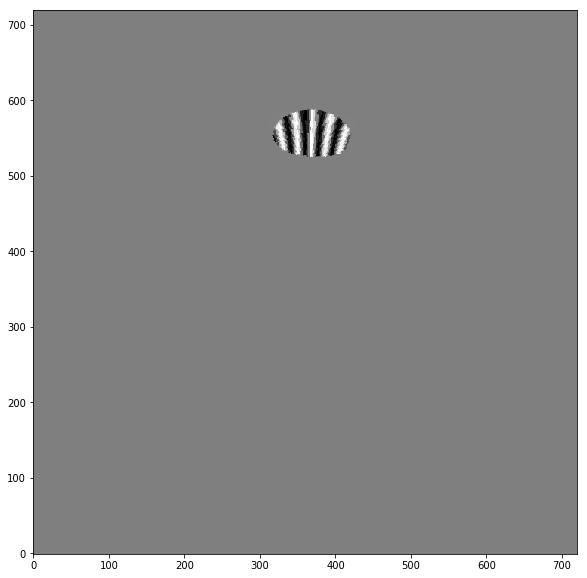

In [2]:
#%%writefile PanoImage.py
from __future__ import print_function
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from math import cos, pi
import cv2
from time import time
#from loop import loop

class PanoImage:
    '''
    PanoImage class
    
    Description:
        Short: Allows to create images suitable for the PanoDisplay
        Long: - checks that the canvas (output image) has a 2:1 aspect ratio, 
              - allows to place images on the canvas according to angular position,
              - allows to straighten the images so they do not look deformed/smaller near the poles,
              - allows access to image's pixel value and angular position via getImage() and getAngleMatrix(), or __get__
    
    Possible Todos: - could eventually allow other coordinate systems than spheric.
    
    Inputs: - Image (PIL or numpy array), so typically 2D array with 3 channels (RGB), example shape=(794,894,3)
            - angular position [lon, lat] in degrees
            - angular matrix if angular position not given, same size as image but angular positions for each pixel
              instead of RGB values.
            - coordinate system, only 'spheric' for now, eventually more later
            - resolution [width, height] in pixels, for a 'spheric' coordinate system the aspect ratio must be 2:1
            
    Outputs:- Instance of the PanoImage class via constructor and compress/stretch.
            - np.array via methods getArray() and getAngleMatrix()
            - matplotlib plot with show()
            
    Example:
                im = cv2.imread('res/test_img.png')
                a = PanoImage(im, units = 'deg', size=[30,30], pos_angles=[0,-40]).stretch()

                # xmap = np.loadtxt('res/xymappings/500x250/xmap.txt', dtype=np.float32)
                # ymap = np.loadtxt('res/xymappings/500x250/ymap.txt', dtype=np.float32)
                # b = a.toPano(xmap,ymap)

                b = a.apply()

                plt.figure(figsize=[10,10])
                plt.imshow(b,origin='lower')
                #cv2.imwrite('res/panocircle.png', b)

    '''
    WIDTH = 500
    HEIGHT = 250 
    
    def __init__(self, im = None, units = 'deg', pos_angles = None, 
                 size = None, background = None, res = (WIDTH,HEIGHT)):
        '''
        image can be either PIL 'image' (it is transformed in np.array) or numpy array
        units 'pix' or 'deg' for size parameter
        needs pos (longitude, latitude) always in degrees
        size = (x,y)
        #since the visual angles are defined independently from a referential
        #coordinate system the size is set from the center of the equator
        #NB: to get the correct size/aspect ratio all over the screen use stretch()
        you can set a different background (same format as image, but dimensions of res)
        res (width, height) always in pixels   
        '''
        self.BG_COLOR = 127
        
        if im is None:
            print('Info: no array given, loading dummy as array.')
            self.im = self._loadDummy()
        elif type(im) is np.ndarray:
            if im.dtype == 'uint8':
                self.im = im
            else:
                self.im = np.uint8(im)
        else:
            self.im = np.asarray(im,dtype=np.uint8)
            if len(self.im.shape) == 3:
                if self.im.shape[2] > 3:
                    self.im = self.im[:,:,:3]
        self.base_im = np.array(self.im)
        
        if units in ('pix', 'deg'):
            self.units = units
        else:
            self.units = 'pix'
            print('Unknown units -> set to pixels.')
            
        if(res[0] == 2*res[1]):
            self.res = res
        else:
            self.res = [2*res[1],res[1]]
            print('Warning: in a spheric coordinate system, the resolution must have a 2:1 aspect ratio: x-coordinate recalculated to fit that requirement: resolution is {0}'.format(self.res))
        
        if background is None:
            self.background = np.full([self.res[1],self.res[0],3], self.BG_COLOR, dtype = np.uint8)
        else:
            self.background = background

        if pos_angles is None:
            self.pos_angles = [0,0]  
        else:
            self.pos_angles = pos_angles
                
        if size is not None:
            if self.units == 'pix':
                self.im = cv2.resize(self.im, size)
            elif self.units == 'deg':
                x_start, x_end = self._lon2x(-size[0]/2, res[0]), self._lon2x(size[0]/2, res[0])
                y_start, y_end = self._lat2y(-size[1]/2, res[1]), self._lat2y(size[1]/2, res[1])
                x, y = x_end - x_start, y_end - y_start
#                 TODO: check that resizing does not unbalance the picture on one side (even -> uneven)
#                 if x%2==1:
#                     x += 1
                self.im = cv2.resize(self.im, (x,y))
            
    def _loadDummy(self):
        '''
        Loads the dummy image in the res folder, then returns it as a numpy array.
        '''
        im = Image.open('res/cat.png')
        arr = np.asarray(im)[:,:,:3]
        return arr
    
    def __getitem__(self, key):
        return self.base_im[key[0],key[1]], self.getAngleMatrix()[key[0],key[1]]
    
    def getImage(self):
        return self.base_im

    def _lon2x(self, lon, tex_width):
        return int(float(lon+180) /180. * tex_width/2.)
    def _lat2y(self, lat, tex_height):
        return int(float(lat+90) /90. * tex_height/2.)
    def _angles2pix(self, angles, tex_dim):
        return (self._lon2x(angles[0], tex_dim[0]),
            self._lat2y(angles[1], tex_dim[1]))
    
    def _x2lon(self,x, tex_width):
        return float(x - tex_width/2)/tex_width *360. 
    def _y2lat(self,y, tex_height):
        return float(y - tex_height/2)/tex_height *180. 
    def _pix2angles(self,pix, tex_dim):
        if type(pix) == list or (len(pix.shape) == 1 and pix.shape[0] == 2):
            return (self._x2lon(pix[0], tex_dim[0]),
                self._y2lat(pix[1], tex_dim[1]))
        else:
            vec_x2lon = np.vectorize(self._x2lon)
            vec_y2lat = np.vectorize(self._y2lat)
            result = np.zeros(pix.shape)
            result[:,:,0] = vec_x2lon(pix[:,:,0], tex_dim[0])
            result[:,:,1] = vec_y2lat(pix[:,:,1], tex_dim[1])
            return result

    def _broadcastRegions(self):
        '''
        The rectangle intersection function takes the Bottom-Left and Top-Right corners
        of two rectangles and returns the Bottom-Left and Top-Right corners of the intersection
        rectangle, or None if they dont intersect.
        Here we need to order the values correctly, because y-axis is inverted.'''
        tex = self.background
        tex_xBL, tex_yBL = 0, 0
        tex_xTR, tex_yTR = tex.shape[1], tex.shape[0]
        
        im = self.im
        w, h = im.shape[1], im.shape[0]
        pos_im = self._angles2pix(self.pos_angles, self.res)
        
        #Take into account the even/odd number of pixels
        if w%2 == 0:
            im_xBL = pos_im[0]-int(w/2)
        else:
            im_xBL = pos_im[0]-int((w+1)/2)
        im_xTR = pos_im[0]+int(w/2)
            
        if h%2 ==0:
            im_yBL = pos_im[1]-int(h/2)
        else:
            im_yBL = pos_im[1]-int((h+1)/2)
        im_yTR = pos_im[1]+int(h/2)

        #Limit conditions for broadcasting
        if self._intersectRectangles(im_xBL, im_yBL, im_xTR, im_yTR, 
                                          tex_xBL, tex_yBL, tex_xTR, tex_yTR) is not None:
            x1,y1,x2,y2 = self._intersectRectangles(im_xBL, im_yBL, im_xTR, im_yTR, 
                                              tex_xBL, tex_yBL, tex_xTR, tex_yTR)
        else:
            raise('The stimulus is completely outside the frame.')
            
        left, bot, right, top = int(x1), int(y1), int(x2), int(y2)
        im_left, im_right = left - im_xBL, right - im_xBL
        im_bot, im_top = bot - im_yBL, top - im_yBL
        
        return top, bot, left, right, im_top, im_bot, im_left, im_right
    
    def apply(self, mask = False):
        '''Applies the image on the background and returns the resulting image.
        The optional mask parameter allows to set the pixels thrown outside the screen
        to a value, so a photodiode (placed on the fisheye) can witness the presence
        of the stimulus.'''
        tex = self.background
        im = self.im
        
        top, bot, left, right, im_top, im_bot, im_left, im_right = self._broadcastRegions()
        tex[top: bot, left: right] = im[im_top: im_bot, im_left:im_right]
        
        if mask:
            lon_limit = 145
            x1_limit = self._lon2x(lon_limit, tex.shape[1])
            x2_limit = self._lon2x(-lon_limit, tex.shape[1])
            lat_limit = 80
            y_limit = self._lat2y(lat_limit, tex.shape[0])
            tex[int(tex.shape[0]/2):,:x2_limit] = \
                tex[int(tex.shape[0]/2):,x1_limit:] = \
                tex[y_limit:,:] = 255
        return tex
        
    def getAngleMatrix(self):
        '''
        Returns a numpy array of lists of tuples.
        Each sublist is a row (longitude), each tuple represents a (longitude, latitude).
        This 'matrix' has the same dimensions as the numpy array holding the image (getArray()), 
        so you can access each pixel per index.'''
        top, bot, left, right, _, _, _, _ = self._broadcastRegions()
        xy_mat = np.array([[(i,j) for i in range(left, right,1) ] for j in range(top, bot, 1)])
        return self._pix2angles(xy_mat, self.res)
    
    def _scalingFactor(self, latitude):
        '''Takes latitude in degrees and outputs the corresponding scaling factor'''
        return 1./cos(1.*latitude/180. *pi)
        
    def _cropImage(self,im):
        '''Allows to crop the image.
        Useful if there are multiple stimuli presented on the same background.
        Should be redone with transparency filter instead: currently the crop is rectangular, which can suck
        if the stimuli are intersecting.'''
        im_copy = np.array(im,dtype=np.uint8)
        im_copy = np.where(im_copy == self.BG_COLOR, 0, im_copy)
        
        gray = cv2.cvtColor(im_copy, cv2.COLOR_BGR2GRAY)
        th, threshed = cv2.threshold(gray, 254, 255, cv2.THRESH_BINARY_INV)

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
        morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

        cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
        cnt = sorted(cnts, key=cv2.contourArea)[-1]

        x,y,w,h = cv2.boundingRect(cnt)
        
        return im[y:y+h, x:x+w]
    
    def _imageDeform(self, compress = False):
        '''
        Performs compression or stretching (default) on the image to apply,
        not on the full (2:1 AR) texture.
        For each pixel of the destination image, finds the corresponding pixel 
        in the source image. Uses interpolation.
        '''
        
        im = self.im

        #Get image borders
        top, bot, left, right, im_top, im_bot, im_left, im_right = self._broadcastRegions()
        im = im[im_top: im_bot, :]
        
        w, h = im.shape[1], im.shape[0]
        
        #Get individual y coordinates
        y = np.arange(top,bot)
        tex = self.background
        
        #Get vector containing scaling factors for each elevation
        vec_y2lat = np.vectorize(self._y2lat)
        vec_scale = np.vectorize(self._scalingFactor)
        to_lat = vec_y2lat(y,self.res[1])
        s = vec_scale(to_lat)
        s = s.reshape(s.shape[0],1)
        
        #Reverse if specified
        if compress:
            s = 1./s
        
        #Get vector containing (h*) lines with x values
        t2 = np.array(([np.arange(w) - float(w)/2] * y.shape[0]))
        
        #Multiply scaling factors with x coordinates
        tmp = np.float32(np.multiply(t2,s))
        
        #Restrict to 16 bits precision and convert
        tmp[(tmp>32767)] = 32767
        tmp[(tmp<-32768)] = -32768
        x = np.array(tmp, dtype = np.int16)
        
        #Restrict to the area we can effectively cover to reduce computing time
        wT = tex.shape[1]
        x[(x <= -wT)] = -wT
        x[(x >= wT)] = wT-1

        #Initialize maps
        xmap = np.full((h,wT*2),w+1, np.float32)
        ymap = np.zeros((h,wT*2), np.float32)
        
        #Update maps - wrote loop with Cython
        #loop(x,xmap,ymap,w,h, wT)
        flagSecondInterval = False
        start2 = 0
        tmp = 2*wT
        for j in range(h):
            for i in range(w): 
                if x[j,i] == 0: #limit condition
                    i2 = i -1
                    start = x[j,i2] #negative
                    stop = tmp
                    start = tmp + start
                    for l in range(start,stop):
                        xmap[j, l] = i 
                        ymap[j, l] = j
                else:
                    if i != 0:
                        i2 = i -1
                        start = x[j,i2]
                        stop = x[j,i]

                        if start < 0: #if start negative stop needs to be negative, if it is not we need a second interval
                            #to cover the central part of the image and avoid a black vertical line
                            start = tmp + start
                            if stop <= 0:
                                stop =  tmp + stop
                            else:
                                flagSecondInterval = True
                                stop2 = stop
                                stop = tmp

                        for l in range(start, stop):
                            xmap[j, l] = i
                            ymap[j, l] = j

                        if flagSecondInterval:
                            for l in range(start2, stop2):
                                xmap[j, l] = i
                                ymap[j, l] = j
                            flagSecondInterval = False
        #Resize the original image: the remap function can only remap pixels from and to the original image
        #so we place it on a larger background
        resized_im = np.full((h,wT*2,3), self.BG_COLOR, dtype=np.float32)
        resized_im[:, : im.shape[1]] = im
        
        #So far the maps were symmetric around 0, we change that for the remap function
        xmap = np.hstack((xmap[:,-wT:], xmap[:,:wT]))
        ymap = np.hstack((ymap[:,-wT:], ymap[:,:wT]))
        
        #CV2 remap
        remapped_im = cv2.remap(resized_im, xmap, ymap, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
        
        #We rectangularly crop the image by detecting the background-foreground elements and removing background
        #cropped_im = self._cropImage(remapped_im)
        
        #Get new image position on canvas, necessary if parts of the image are outside the frame
        new_pos_pix_y = np.array([int((bot+top)/2)])
        new_pos_angles_y = self._y2lat(new_pos_pix_y, self.res[1])
        
        return PanoImage(remapped_im, units=self.units, background = self.background,pos_angles=(self.pos_angles[0],new_pos_angles_y))
    
    def compress(self):
        return self._imageDeform(compress = True)
    def stretch(self):
        return self._imageDeform()
    
    def toPano(self, xmap, ymap,  h = 720, size = None):
        '''Maps a panoimage (2D image with 2:1 aspect ratio) to the dome.
        The xmap and ymap need to be generated with the PanoDisplay generateMappingData function
        for every different position of the projector-optical bloc setup.'''
        im = self.apply()
        im = cv2.flip(im, 1)
        #im = np.hstack((im[:,-int(im.shape[1]/2):], im[:,:int(im.shape[1]/2)]))
        if size is not None:
            im = cv2.resize(im,size)
        else:
            im = cv2.resize(im,(500,250))
        im = np.float32(im)/255
        resized_im = np.full((2048,2048,3), self.BG_COLOR, dtype=np.float32)
        resized_im[:im.shape[0], : im.shape[1]] = im

        new_im = cv2.remap(resized_im, xmap, ymap,cv2.INTER_LINEAR, None,cv2.BORDER_REPLICATE)
        new_im = cv2.resize(new_im,(h,h))

        #pano_im = np.full((h,w,3), self.BG_COLOR, dtype=np.float32)
        #pano_im[:new_im.shape[0], 240: new_im.shape[1]+240] = new_im
        return new_im
        
    def _intersectRectangles(self,x1, y1, x2, y2, x3, y3, x4, y4):
        '''Get the intersection points of two intersecting rectangles.'''
        # gives bottom-left point of intersection rectangle 
        x5, y5 = max(x1, x3), max(y1, y3)
        # top-right point 
        x6, y6 = min(x2, x4), min(y2, y4) 
        # no intersection 
        if (x5 > x6 or y5 > y6) : 
            return None
        # gives top-left point  
        x7, y7 = x5, y6
        # gives bottom-right point 
        x8, y8 = x6, y5
        return x7,y7,x8,y8
    
    def contrastCorrectionFisheye(self, bmap):
        '''This function aims to compensate the lens imperfect brightness distribution.
        The lens is expected to have better brightness in the center, worse at the periphery.
        
        The brightness map is established with a Luxmeter. 
        The map consists in 5 points of elevation and 7 points of longitude, so 35 points total.
        
        The image projected is a uniform black background with a white circle of roughly 5 degrees radius.
        The measurement is made in the center of the white circle.
        The goal is to negate the effect of the rest of the screen (as it has been measured that a black
        image's contrast is balanced over the full screen).
        
        On a greyscale, since we can not increase the white further (it can not get whiter), we have to decrease 
        the higher values.'''
        return
    
    def getContrastCorrectionScreenValue(self, bmap):
        '''This function aims to compensate the screen imperfect brightness distribution.
        This is due to the spherical nature of the screen: rays bounce inside of it, causing the left-right parts to appear
        brighter than the center (which faces a dark room) if a uniform white image is being displayed.
        Note: it has to be applied after the contrastCorrectionFisheye, as the fisheye imperfection can not be negated.
        
        Because every different image projected will lead to different color and brightness distributions, the contrast 
        needs to be corrected image per image. That correction consists in the addition of a low-passed 'central symmetry' 
        reversed version of the image, by a certain amount.
        That amount of correction needed is dependent on the screen (size and paint are its parameters - if you change
        one of those, you will need to calibrate your screen again), that will be determined once with this function.
        It also depends on every image used.
        The central part faces a dark room, and therefore does not need any correction.
        The other parts are affected by the screen segments facing them, displaying images. The goal is to negate the effect
        on brightness of those pictures (but, obviously, without making them dark). This will be done by estimating the average
        brightness on every facing sub-segments (1 degree wide), giving them weights following a gaussian curve, and 
        lowering the brightness of our final (non-facing) segment accordingly.
        
        The constraint is to achieve a 10% margin on the global contrast (so approximative it will be).
        
        The brightness map is established with a Luxmeter.
        The map consists in 5 points of elevation and 7 points of longitude, so 35 points total.
        
        The image projected is a uniform white. This image has the maximal impact on contrast imperfections.
        We will just apply the correction until it appears contrast perfect (measuring extreme points and center only
        for rapid checking).
        Knowing that a black image is contrast perfect without correction, we can start a curve.
        
        Assumptions: - the system can be sub-segmented
                     - a rough discrete gaussian applies
        '''
        return


if __name__ == '__main__':
    im = cv2.imread('res/test_img.png')
    a=PanoImage(im, units = 'deg', size=[30,30], pos_angles=[0,-40]).stretch()

    xmap = np.loadtxt('res/xmap.txt', dtype=np.float32)
    ymap = np.loadtxt('res/ymap.txt', dtype=np.float32)
    b = a.toPano(xmap,ymap)

    #b = a.apply()

    plt.figure(figsize=[10,10])
    plt.imshow(b,origin='lower')
    #cv2.imwrite('res/panocircle.png', b)

In [2]:
%load_ext cython

In [3]:
%%writefile loop.pyx

###cython: boundscheck=False, wraparound=False, nonecheck=False
#%%cython --annotate

#First comment are compiler directives.

#This cython implementation massively speeds up the loop in imageDeform
#...at the cost of conciseness, see below for slower, easier to understand version of imageDeform

from cython.parallel import prange

cpdef loop(short[:,::1] x,float[:,::1] xmap,float[:,::1] ymap, int w, int h, int wT):
    cdef:
        Py_ssize_t j
        Py_ssize_t i
        Py_ssize_t i2
        Py_ssize_t l
        short start
        short stop
        
        short flagSecondInterval = False
        short start2 = 0
        short stop2
        
        short tmp = 2*wT
    for j in range(h):
        for i in range(w): 
            if x[j,i] == 0: #limit condition
                i2 = i -1
                start = x[j,i2] #negative
                stop = tmp
                start = tmp + start
                for l in range(start,stop):
                    xmap[j, l] = i 
                    ymap[j, l] = j
            else:
                if i != 0:
                    i2 = i -1
                    start = x[j,i2]
                    stop = x[j,i]
                    
                    if start < 0: #if start negative stop needs to be negative, if it is not we need a second interval
                        #to cover the central part of the image and avoid a black vertical line
                        start = tmp + start
                        if stop <= 0:
                            stop =  tmp + stop
                        else:
                            flagSecondInterval = True
                            stop2 = stop
                            stop = tmp

                    for l in range(start, stop):
                        xmap[j, l] = i
                        ymap[j, l] = j
                        
                    if flagSecondInterval:
                        for l in range(start2, stop2):
                            xmap[j, l] = i
                            ymap[j, l] = j
                        flagSecondInterval = False
                        

Overwriting loop.pyx


In [6]:
'''
#Imagedeform loop - Non vectorized version - more intelligible, slow
x_old = 0
for j in range(h):
    y = int(posT[1] - float(h)/2 + j) #vector y
    if 0 <= y < tex.shape[0]:
        s = self._scalingFactor(self._pix2angles(np.array([0,y]),self.res)[1]) #vector s
        if compress:
            s = 1./s
        for i in range(w):
            x = int(s*(i - float(w)/2)) #vector x
            if -wT <= x < wT:
                if x == 0: #limit conditions for negative indexes
                    xmap[j, x_old:] = i #list comprehensions
                    ymap[j, x_old:] = j
                else:
                    xmap[j, x_old:x] = i
                    ymap[j, x_old:x] = j

                x_old = x
'''
%prun b = a.toPano(xmap,ymap)